<a href="https://colab.research.google.com/github/JuniorHZ19/ArquitecturasCNN/blob/main/CNNSIMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
#CNN SIMPLE:
import torch.nn as nn
import torch.optim as optim

# Definir un modelo simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.maxpool=nn.MaxPool2d(kernel_size=2)

        self.flatten=nn.Flatten(start_dim=1)

        self.relu=nn.ReLU()

        self.fc1 = nn.Linear(128*5*5, 128)

        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 10)

        self.dropout=nn.Dropout(0.5)


    def forward(self, x):

        x = self.conv1(x)
        x=self.relu(x)

        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.flatten(x)

        x=self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x=self.dropout(x)
        x = self.relu(x)


        x=self.fc3(x)


        return x

In [24]:
def accurity(predicciones,etiquetas_reales,multiclase=False):

  if(multiclase==False):

    predicciones_clase=predicciones.round()

  else:

    predicciones_clase=torch.argmax(predicciones,dim=1) #toma dim=1 el indice maximo de la fila

  aciertos=(predicciones_clase.squeeze()==etiquetas_reales).sum().item()

  accuraty=aciertos/len(etiquetas_reales)

  return accuraty

In [25]:
def trainModel(model,epochs,dataLoader,dataLoader_test,optimiser,funcion_loss,multiclase=True):

  for epoch in range(epochs):

    epoch_loss=0

    model.train()

    for batch_data,batch_labels in (dataLoader):

       output=model(batch_data)

       loss=funcion_loss(output,batch_labels)

       optimiser.zero_grad()

       loss.backward()

       optimiser.step()

       epoch_loss +=loss.item()

    model.eval()
    accurity_total=0
    with torch.no_grad():

      for batch_data,batch_labels in (dataLoader_test):

        output=model(batch_data)

        accurity_total+=accurity(output,batch_labels,multiclase)


    accurity_promedio=accurity_total/len(dataLoader_test) # se calcula un accirty total de todos los batchs y se divide entre el total de batches para tener un promedio

    epoch_loss/=len(dataLoader)

    print(f"Época {epoch+1}, Pérdida : {epoch_loss:.4f} , Accurity:{accurity_promedio:.4f}")


  return model,optimiser



Files already downloaded and verified
Files already downloaded and verified


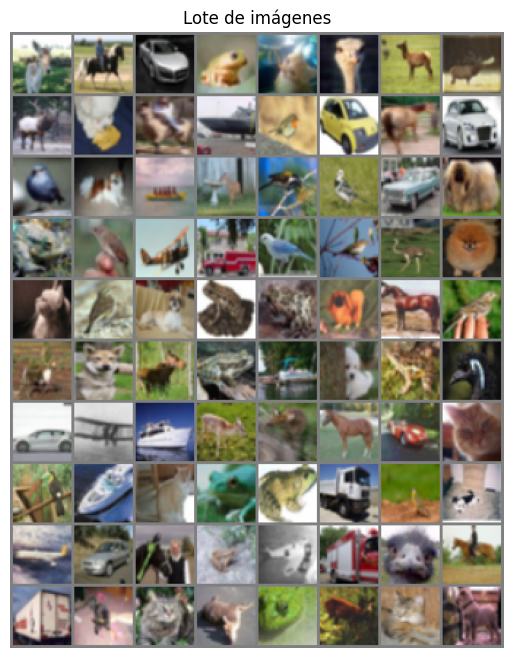

In [34]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones básicas para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Resize((40,40)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar a [-1, 1]
])

# Cargar el dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False, num_workers=2)


data_lote,labels_lote=next(iter(train_loader))

grid = make_grid(data_lote, nrow=8, padding=2)

# Convertir la cuadrícula a formato visualizable
grid_np = grid.permute(1, 2, 0).numpy()
grid_np = (grid_np * 0.5) + 0.5  # Desnormalizar si las imágenes están normalizadas

# Mostrar la cuadrícula
plt.figure(figsize=(20, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Lote de imágenes')
plt.show()

In [ ]:
# Inicializar modelo, pérdida y optimizador
modelo = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.001, betas=(0.9,0.999))
epochs=15

trainModel(modelo,epochs,train_loader,test_loader,optimizer,criterion)

Época 1, Pérdida : 1.6750 , Accurity:0.5346
Época 2, Pérdida : 1.2484 , Accurity:0.6287
Época 3, Pérdida : 1.0434 , Accurity:0.6725
Época 4, Pérdida : 0.9141 , Accurity:0.6983
Época 5, Pérdida : 0.7921 , Accurity:0.7209
Época 6, Pérdida : 0.7066 , Accurity:0.7261
Época 7, Pérdida : 0.6254 , Accurity:0.7231
Época 8, Pérdida : 0.5567 , Accurity:0.7290
Época 9, Pérdida : 0.4964 , Accurity:0.7380


In [ ]:
# Inicializar modelo, pérdida y optimizador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Entrenamiento simple
for epoch in range(20):  # Número de épocas
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Resetear gradientes
        outputs = model(inputs)  # Paso hacia adelante
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Paso hacia atrás
        optimizer.step()  # Actualizar pesos
        running_loss += loss.item()

    print(f"Época {epoch+1}, Pérdida: {running_loss/len(train_loader)}")

correct = 0
total = 0
model.eval()
with torch.no_grad():  # Desactivar el cálculo de gradientes para la prueba
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Precisión: {100 * correct / total:.2f}%")

Época 1, Pérdida: 1.813167053567784
Época 2, Pérdida: 1.3927686280759095
Época 3, Pérdida: 1.1733326734331868
Época 4, Pérdida: 1.0238987427690756
Época 5, Pérdida: 0.9072663845003718
Época 6, Pérdida: 0.8281599627355175
Época 7, Pérdida: 0.7536372669288874
Época 8, Pérdida: 0.6922310383804618
Época 9, Pérdida: 0.639602112419465
Época 10, Pérdida: 0.5921642982670109
Época 11, Pérdida: 0.5481664574778903
Época 12, Pérdida: 0.5153822527288476
Época 13, Pérdida: 0.478664482722197
Época 14, Pérdida: 0.4466561248807041
Época 15, Pérdida: 0.41183832392591957
Época 16, Pérdida: 0.40416208429790823
Época 17, Pérdida: 0.3740951964807937
Época 18, Pérdida: 0.3521819371167961
Época 19, Pérdida: 0.32892572080425897
Época 20, Pérdida: 0.3122766107473227
Precisión: 74.94%


In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Precisión: {100 * correct / total:.2f}%")

Precisión: 69.63%
